The provided code is an implementation of a simple reinforcement learning (RL) trading agent that uses Deep Q-Networks (DQN) to make buy and sell decisions in a stock trading environment. Let's break down the code step by step:
Data Retrieval and Preprocessing

    Import necessary libraries, including yfinance for fetching stock data, pandas for data manipulation, numpy for numerical operations, torch for deep learning, and others.

    Define a list of stock tickers, e.g., ["NVDA"], for which you want to fetch historical data.

    Implement a fetch_data function that downloads historical stock data for the specified tickers. It calculates daily returns and adds 50-day and 200-day simple moving averages (SMA) as features to the data. The data is stored in a dictionary with ticker names as keys.

    Retrieve the stock data for the specified ticker(s), e.g., "NVDA," and store it in the df variable.

Environment Definition

    Define a custom trading environment called StockTradingEnv. This environment represents a simplified trading scenario. It has the following attributes and methods:

        __init__(self, data, trading_cost=2.00): Initializes the environment with historical stock data and a trading cost parameter (default 2.00, representing a 2% trading fee).

        reset(self): Resets the environment to its initial state, including the balance and total reward. Returns the normalized state of the first data point.

        step(self, action): Takes an action (0 for hold, 1 for buy, 2 for sell), computes the reward based on the action and trading cost, and updates the environment's state. Returns the next state, reward, a flag indicating if the episode is done, and additional information (empty dictionary).

        normalize_state(self, state): Normalizes the state features to the range [0, 1] using MinMaxScaler.

        action_space(self): Returns the number of possible actions (3 in this case: hold, buy, and sell).

        observation_space(self): Returns the dimensionality of the observation space, which is the number of columns in the data.

DQN Agent Definition

    Define a DQN agent called DQNAgent responsible for learning and making trading decisions. It has the following key attributes and methods:

        __init__(self, state_size, action_size): Initializes the agent with the size of the state and action spaces. It sets hyperparameters such as discount rate (gamma), exploration rate (epsilon), and builds the neural network model for Q-learning.

        _build_model(self): Constructs a neural network model using PyTorch's nn.Sequential with three fully connected layers.

        remember(self, state, action, reward, next_state, done): Stores a transition (state, action, reward, next_state, done) in the agent's replay memory.

        act(self, state): Selects an action based on an epsilon-greedy strategy. With probability epsilon, it chooses a random action; otherwise, it selects the action with the highest estimated Q-value from the neural network.

        replay(self, batch_size): Performs experience replay by sampling a batch of transitions from the replay memory and updating the Q-network using the Bellman equation and mean squared error loss.

        load(self, name) and save(self, name): Methods to load and save the model's weights.

Training Loop

    In the training loop, the RL agent interacts with the trading environment, learns from its experiences, and updates its Q-network.

        Create an instance of the StockTradingEnv for the specified ticker(s) and initialize the state and action spaces.

        Iterate through a predefined number of episodes (e.g., 500).

        For each episode, reset the environment and initialize variables to track trade count.

        In the inner loop, interact with the environment, selecting actions using the agent's act method, and accumulating rewards. If the action is a buy or sell, increment the trade count.

        After an episode is complete, store episode-related information (episode number, total reward, trade count, epsilon) in the results list.

        Periodically, execute the replay method to update the Q-network using experience replay.

        Finally, convert the training results to a Pandas DataFrame and save it to an Excel file ("agent_results_3.xlsx").

Trading Costs

    Trading costs are considered in the reward calculation, reducing the reward for buy and sell actions by a specified percentage (trading_cost) to account for trading fees.

The code provides a basic RL-based trading framework for experimenting with trading strategies. However, it's essential to note that this is a simplified model and does not account for many real-world complexities, such as slippage, transaction volume, and market impact. Real-world trading applications should be developed with caution and consider additional factors for accurate simulations.

In [25]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random
from sklearn.preprocessing import MinMaxScaler

# Get stock data
tickers = ["NVDA"]  # Add all 30 here

def fetch_data(tickers):
    data = {}
    for ticker in tickers:
        stock_data = yf.download(ticker, start="2021-01-01", end="2023-11-01", progress=False)
        stock_data['Return'] = stock_data['Close'].pct_change()

        # Calculate moving averages (e.g., 50-day and 200-day moving averages)
        stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
        stock_data['SMA_200'] = stock_data['Close'].rolling(window=200).mean()

        data[ticker] = stock_data.dropna()
    return data

data = fetch_data(tickers)
df = data

# Define the environment
class StockTradingEnv:
    def __init__(self, data, trading_cost= 2.00):  # Example trading cost of 1%
        self.data = data
        self.trading_cost = trading_cost
        self.index = 0
        self.done = False
        self.total_reward = 0
        self.initial_balance = 10000.0
        self.balance = self.initial_balance

    def reset(self):
        self.index = 0
        self.done = False
        self.total_reward = 0
        self.balance = self.initial_balance
        state = self.data.iloc[self.index].values
        return self.normalize_state(state)

    def step(self, action):
        # 0->Hold, 1->Buy, 2->Sell
        current_row = self.data.iloc[self.index]
        next_row = self.data.iloc[self.index + 1]
        reward = 0
        predicted_close = current_row['Close']  # Default to current close

        if action == 1:  # Buy
            reward = (next_row['Close'] - current_row['Open']) * (1.0 - self.trading_cost)
            predicted_close = next_row['Open']  # Predicting increase
        elif action == 2:  # Sell
            reward = (current_row['Open'] - next_row['Close']) * (1.0 - self.trading_cost)
            predicted_close = next_row['Open']  # Predicting decrease

        self.total_reward += reward
        self.index += 1

        if self.index >= len(self.data) - 1:
            self.done = True
            self.index = 0  # Reset for next episode

        next_state = self.data.iloc[self.index + 1].values
        return self.normalize_state(next_state), reward, self.done, {}

    def normalize_state(self, state):
        # Normalize state features to the range [0, 1]
        scaler = MinMaxScaler()
        scaled_state = scaler.fit_transform(state.reshape(-1, 1))
        return scaled_state.flatten()

    def action_space(self):
        return 3

    def observation_space(self):
        return len(self.data.columns)

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, self.action_size)
        )
        self.optimizer = optim.Adam(model.parameters(), lr=self.learning_rate)
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))


    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        state_tensor = torch.FloatTensor(state).float()  # Ensure it's a FloatTensor
        act_values = self.model(state_tensor)
        return torch.argmax(act_values).item()

    def replay(self, batch_size):
      minibatch = random.sample(self.memory, batch_size)
      criterion = nn.MSELoss()  # Define the loss criterion
      for state, action, reward, next_state, done in minibatch:
          state_tensor = torch.FloatTensor(state).float()  # Ensure it's a FloatTensor
          next_state_tensor = torch.FloatTensor(next_state).float()  # Ensure it's a FloatTensor

          if not done:
              target = reward + self.gamma * torch.max(self.model(next_state_tensor)).item()
          else:
              target = reward
          target_tensor = torch.tensor([target], dtype=torch.float32)

          current_value = self.model(state_tensor).squeeze()[action].unsqueeze(0)  # Adjusted for the correct shape
          loss = criterion(current_value, target_tensor)

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()
      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay


    def load(self, name):
          self.model.load_state_dict(torch.load(name))


    def save(self, name):
        torch.save(self.model.state_dict(), name)

# Training loop
env = StockTradingEnv(df['NVDA'])
state_size = env.observation_space()
action_size = env.action_space()
agent = DQNAgent(state_size, action_size)

EPISODES = 500

results = []

for e in range(EPISODES):
    trade_count = 0  # Reset trade count for each episode
    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        if action == 1 or action == 2:  # Buy or sell action
            trade_count += 1
        state = next_state
        if done:
            print(f"episode: {e+1}/{EPISODES}, reward: {env.total_reward}, trades: {trade_count}, epsilon: {agent.epsilon:.2}")
            results.append({
                "Episode": e+1,
                "Reward": env.total_reward,
                "Trades": trade_count,
                "Epsilon": agent.epsilon
            })

    if len(agent.memory) > 32:
        agent.replay(32)

# Convert the results to a pandas DataFrame and save to Excel
results_df = pd.DataFrame(results)
results_df.to_excel("agent_results_3.xlsx", index=False)

episode: 1/500, reward: -150.88030242919922, trades: 353, epsilon: 1.0
episode: 2/500, reward: -147.17974090576172, trades: 308, epsilon: 0.99
episode: 3/500, reward: 19.760391235351562, trades: 345, epsilon: 0.99
episode: 4/500, reward: 324.97999572753906, trades: 325, epsilon: 0.99
episode: 5/500, reward: -81.6399917602539, trades: 336, epsilon: 0.98
episode: 6/500, reward: -218.36016845703125, trades: 343, epsilon: 0.98
episode: 7/500, reward: 50.79014587402344, trades: 315, epsilon: 0.97
episode: 8/500, reward: -56.90995788574219, trades: 331, epsilon: 0.97
episode: 9/500, reward: -205.49002075195312, trades: 328, epsilon: 0.96
episode: 10/500, reward: -221.55980682373047, trades: 327, epsilon: 0.96
episode: 11/500, reward: 350.7400588989258, trades: 330, epsilon: 0.95
episode: 12/500, reward: -182.29991149902344, trades: 325, epsilon: 0.95
episode: 13/500, reward: 200.25018310546875, trades: 334, epsilon: 0.94
episode: 14/500, reward: 41.359840393066406, trades: 331, epsilon: 0.94

<Axes: >

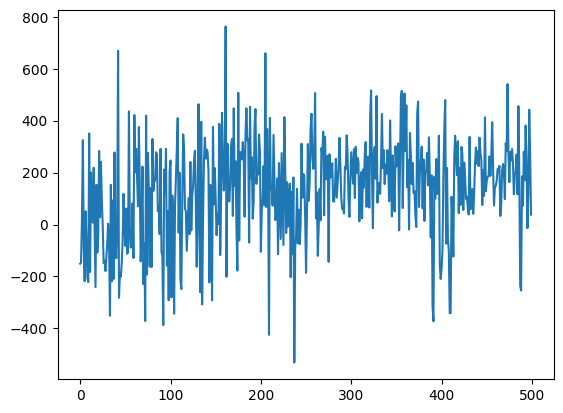

In [26]:
import pandas as pd
df = pd.read_excel('agent_results_3.xlsx')
df['Reward'].plot()

In [27]:
results_df['Cumulative_Return'] = results_df['Reward'].cumsum()
initial_balance = 10000.0  # Same as the initial_balance defined in the environment
results_df['ROI'] = (results_df['Cumulative_Return'] / initial_balance) * 100


In [28]:
print(results_df)


     Episode      Reward  Trades   Epsilon  Cumulative_Return         ROI
0          1 -150.880302     353  1.000000        -150.880302   -1.508803
1          2 -147.179741     308  0.995000        -298.060043   -2.980600
2          3   19.760391     345  0.990025        -278.299652   -2.782997
3          4  324.979996     325  0.985075          46.680344    0.466803
4          5  -81.639992     336  0.980150         -34.959648   -0.349596
..       ...         ...     ...       ...                ...         ...
495      496  -14.109886     499  0.083642       65179.825714  651.798257
496      497  118.750183     492  0.083224       65298.575897  652.985759
497      498  441.819977     499  0.082808       65740.395874  657.403959
498      499  270.919983     501  0.082394       66011.315857  660.113159
499      500   38.030167     492  0.081982       66049.346024  660.493460

[500 rows x 6 columns]


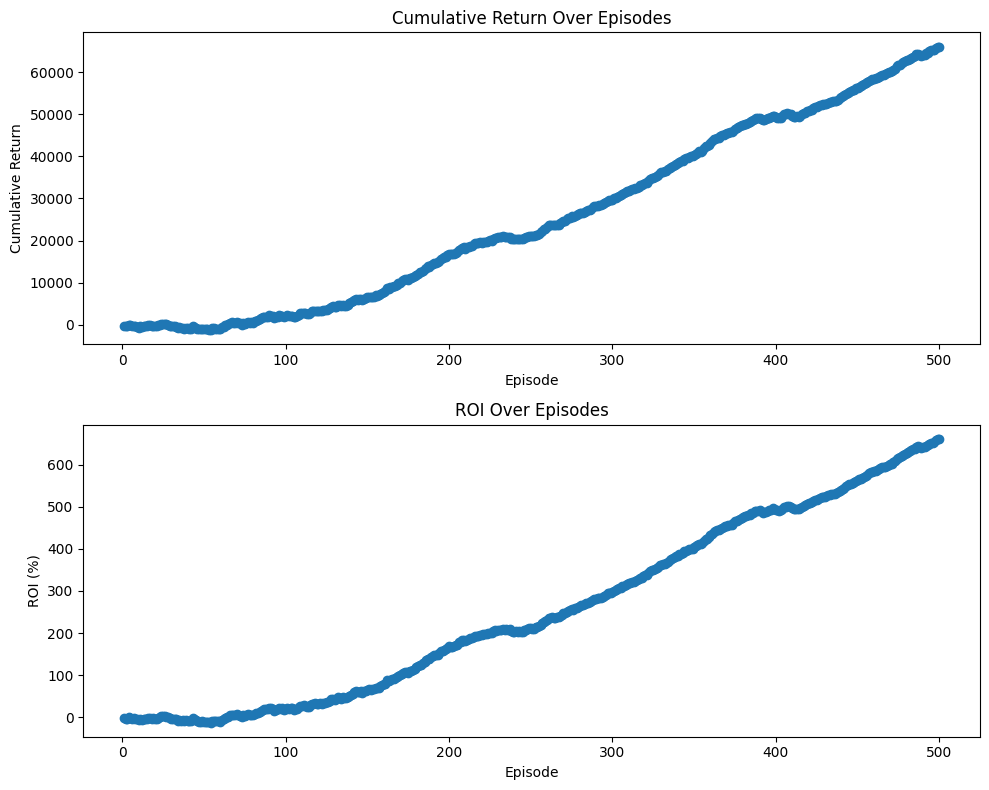

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results from the "agent_results_3.xlsx" file
results_df = pd.read_excel("agent_results_3.xlsx")

# Calculate the cumulative returns
#initial_balance = 10000.0
results_df['Cumulative_Return'] = results_df['Reward'].cumsum()

# Calculate the ROI
results_df['ROI'] = (results_df['Cumulative_Return'] / initial_balance) * 100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot Cumulative Returns
ax1.plot(results_df['Episode'], results_df['Cumulative_Return'], marker='o', linestyle='-')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Cumulative Return')
ax1.set_title('Cumulative Return Over Episodes')

# Plot ROI
ax2.plot(results_df['Episode'], results_df['ROI'], marker='o', linestyle='-')
ax2.set_xlabel('Episode')
ax2.set_ylabel('ROI (%)')
ax2.set_title('ROI Over Episodes')

# Adjust subplot spacing
plt.tight_layout()

# Show the plots
plt.show()


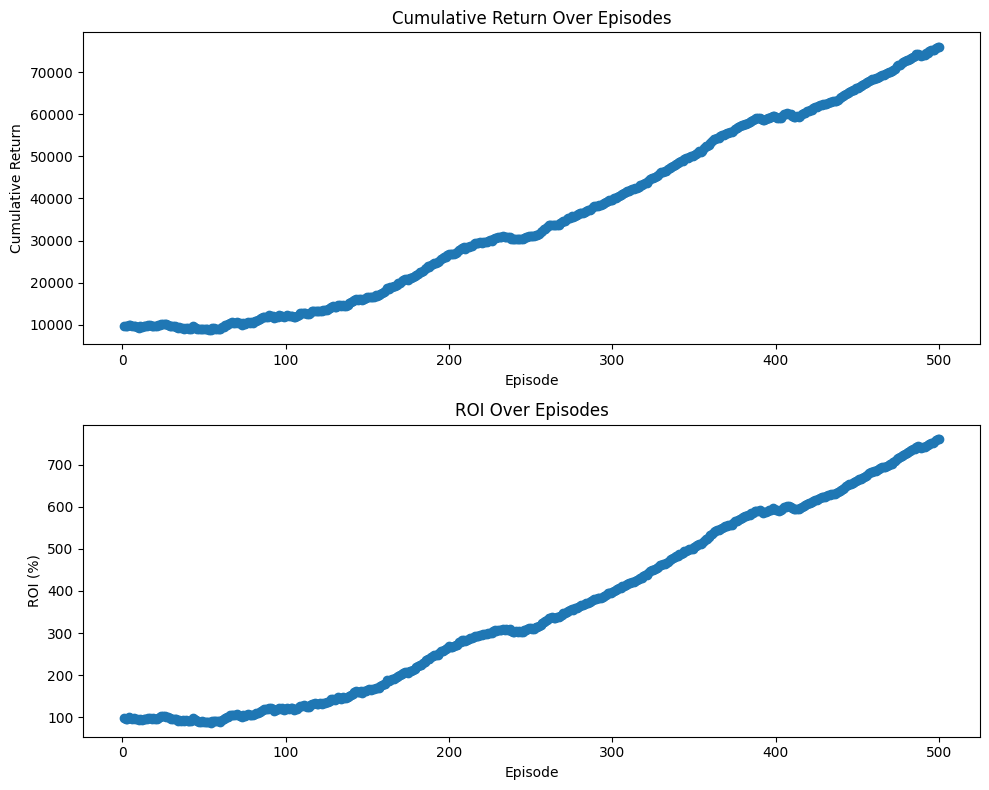

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results from the "agent_results_3.xlsx" file
results_df = pd.read_excel("agent_results_3.xlsx")

# Calculate the cumulative returns
initial_balance = 10000.0
results_df['Cumulative_Return'] = initial_balance + results_df['Reward'].cumsum()  # Adjusted for initial balance

# Calculate the ROI
results_df['ROI'] = (results_df['Cumulative_Return'] / initial_balance) * 100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot Cumulative Returns
ax1.plot(results_df['Episode'], results_df['Cumulative_Return'], marker='o', linestyle='-')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Cumulative Return')
ax1.set_title('Cumulative Return Over Episodes')

# Plot ROI
ax2.plot(results_df['Episode'], results_df['ROI'], marker='o', linestyle='-')
ax2.set_xlabel('Episode')
ax2.set_ylabel('ROI (%)')
ax2.set_title('ROI Over Episodes')

# Adjust subplot spacing
plt.tight_layout()

# Show the plots
plt.show()


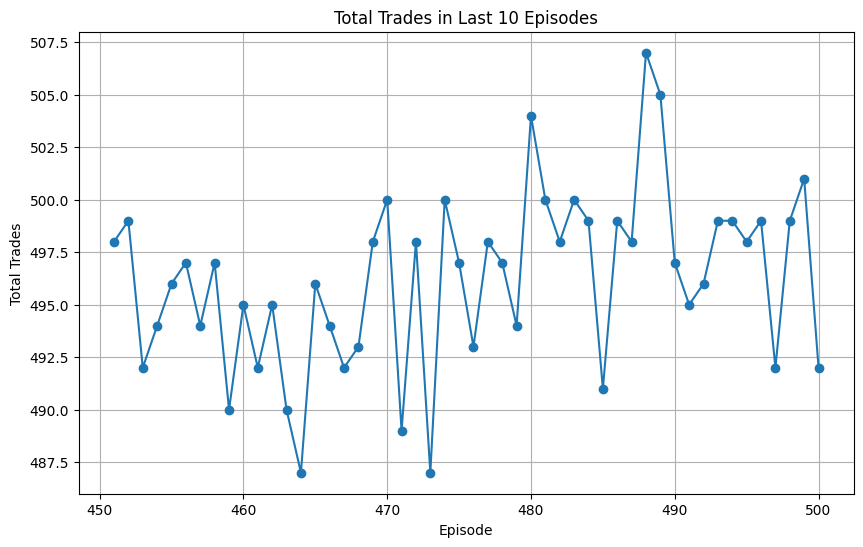

In [34]:
import matplotlib.pyplot as plt

# Assuming results_df contains your episode results data
last_10_results = results_df.tail(50)
episodes = last_10_results['Episode']
trade_counts = last_10_results['Trades']

plt.figure(figsize=(10, 6))
plt.plot(episodes, trade_counts, marker='o', linestyle='-')
plt.xlabel('Episode')
plt.ylabel('Total Trades')
plt.title('Total Trades in Last 10 Episodes')
plt.grid(True)
plt.show()


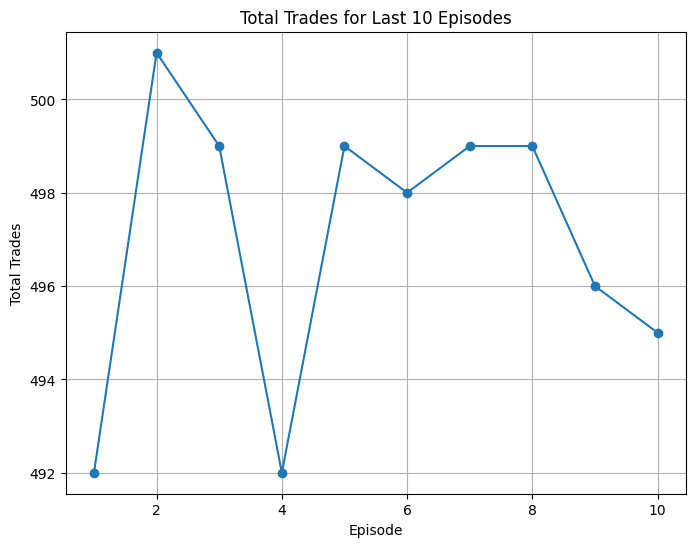

In [32]:
# Calculate total trades for the last 10 episodes
last_10_episodes = results_df[-10:]  # Get the last 10 episodes' data
trade_counts = last_10_episodes['Trades'].values[::-1]  # Reverse the order of trade counts

# Create a figure and plot the trade counts
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), trade_counts, marker='o', linestyle='-')
plt.xlabel('Episode')
plt.ylabel('Total Trades')
plt.title('Total Trades for Last 10 Episodes')
plt.grid(True)

# Show the plot
plt.show()


Once you have trained your reinforcement learning (RL) model, you can use it for making trading decisions on unseen data, also known as the inference or testing phase. Here are the general steps to use your trained RL model:

    Load the Trained Model: Load the weights of your trained RL model. Most RL frameworks and libraries provide mechanisms for saving and loading model weights.

    Initialize the Environment: Create an instance of your trading environment for the testing period. Ensure that it is set up the same way as during training, including data preprocessing and normalization.

    Run Inference Loop: In the inference loop, you'll follow a similar process as in the training loop but without any exploration (no epsilon-greedy exploration). Instead, you'll use the RL model to make predictions and trading decisions.

    python

    # Pseudocode for the inference loop
    while not done:
        state = env.get_state()  # Get the current state from the environment
        action = agent.infer_action(state)  # Use the RL model to make an action prediction
        next_state, reward, done, _ = env.step(action)  # Execute the action and get the next state and reward
        # Store results or take further actions as needed

    Collect Results: During the inference loop, you can collect various results, such as portfolio performance, cumulative returns, and trading statistics.

    Evaluate Model Performance: Assess how well your trained RL model performs on the unseen data. You can use various evaluation metrics, such as the Sharpe ratio, maximum drawdown, or any other metrics that are relevant to your trading strategy.

    Optimize and Refine: Depending on the results of the evaluation, you may need to fine-tune your RL model or adjust your trading strategy. Continuous monitoring and refinement are crucial for adapting to changing market conditions.

    Execute Real Trades: If you are satisfied with the model's performance during testing and are confident in its ability to make profitable trades, you can consider using it for actual trading in real financial markets. This step involves integrating your RL model with a trading platform or brokerage API to automate trading based on the model's decisions.

It's important to note that deploying an RL-based trading strategy in a real-world trading environment carries risks, and you should exercise caution. Always start with a small portion of your capital and carefully monitor the performance of your model before scaling up.

Additionally, trading strategies often require continuous adaptation to changing market conditions, news events, and other factors. Regularly retraining and updating your RL model is essential to ensure its effectiveness over tim